# Linear Regresion - comparison of model using entire dataset and multiple models.

Based in previous Jupyter Notebook: Database Connection - Linear Regression - Spliting dataset into Train and Test sets

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- train model and evaluate results

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:

`$   pip install psycopg2`

`$   pip install psycopg2-binary `

In [1]:
%matplotlib inline

In [2]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.datasets as datasets

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [3]:
#!pip install psycopg2

In [4]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [5]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [6]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# List tables in database
inspect(engine).get_table_names()

['economic_features_full',
 'features_table',
 'target_table',
 'economic_features',
 'high_low_poverty']

In [9]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [10]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [11]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86


## Additional data processing

In [12]:
# Calculate additional features

econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']


In [13]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million','population_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.head()

,year,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
0,1970,National,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18,277.695251,92.172236
1,1971,National,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05,308.829039,133.149892
2,1972,National,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12,343.443144,147.263564
3,1973,National,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13,361.163357,137.824325
4,1974,National,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86,383.609909,163.997004


## Model using entire dataset

In [14]:
m_df = model_df.dropna().set_index('year')
m_temp_df = m_df.copy()
m_df.drop(columns=['state'], inplace=True)
m_df

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
year,,,,,,,,,,,
1976,467.8,7.786562,5.00,7.79,2.226667,56.900,5.7,9226.48,14.10,494.549310,332.596741
1977,475.9,7.132505,5.10,7.13,2.226667,60.600,6.5,9779.44,13.92,528.450984,380.369984
1978,497.8,6.134198,5.20,6.13,2.226667,65.200,7.6,10556.03,13.43,579.812715,365.539437
1979,548.9,5.923827,5.30,5.92,2.910000,72.600,11.3,11479.46,13.33,625.455698,373.443489
1980,596.6,7.255717,5.20,7.26,3.110196,82.400,13.5,12513.46,14.65,678.387612,477.835406
...,...,...,...,...,...,...,...,...,...,...,...
2015,221.6,4.200000,3.10,69.90,7.250000,237.017,0.1,48098.63,10.60,5102.901024,544.368601
2016,244.7,5.400000,3.01,70.20,7.250000,240.007,1.3,48642.15,10.90,5437.606838,613.333333
2017,234.6,4.300000,2.90,70.40,7.250000,245.120,2.1,50321.89,10.80,5340.172414,620.862069


In [15]:
# Define X and y variables
X = m_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = m_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

X shape: (1844, 10)


,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
1976,467.8,7.786562,5.0,7.79,2.226667,56.9,5.7,9226.48,494.549310,332.596741
1977,475.9,7.132505,5.1,7.13,2.226667,60.6,6.5,9779.44,528.450984,380.369984
1978,497.8,6.134198,5.2,6.13,2.226667,65.2,7.6,10556.03,579.812715,365.539437
1979,548.9,5.923827,5.3,5.92,2.910000,72.6,11.3,11479.46,625.455698,373.443489
1980,596.6,7.255717,5.2,7.26,3.110196,82.4,13.5,12513.46,678.387612,477.835406


In [16]:
# Create a model with scikit-learn
model = LinearRegression()
# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model.fit(X_train, y_train)

LinearRegression()

In [17]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values

#  Predict using all X values for ease of plotting.
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)

# Use y_pred_test to plot testing points
y_pred_test = model.predict(X_test)

(1844,)
(1844, 10)


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y_test,y_pred_test)}')
print(f'Mean square error: {mean_squared_error(y_test,y_pred_test)}')
print(f'r2 score: {r2_score(y_test,y_pred_test)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean absolute error: 2.426802049182823
Mean square error: 10.196339708317764
r2 score: 0.45748234375665453
Coefficients: [ 4.26498807e-03  1.06086037e+00  9.42949895e-03 -3.39021256e-02
  2.63981993e-01 -9.97204285e-02  1.39413678e-01  4.26409796e-04
 -1.92670790e-03 -2.84596010e-03]
Intercept: 16.794198462370925


# R2 score of entire dataset with 80/20 split in Train/Test is 0.51
# Now let's see how a few individual plots look.

In [19]:
m_temp_df['predicted_poverty'] = y_pred
#m_df['state']=model_df.dropna()['state']
m_temp_df.head()

,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,,
1976,National,467.8,7.786562,5.0,7.79,2.226667,56.9,5.7,9226.48,14.10,494.549310,332.596741,24.576083
1977,National,475.9,7.132505,5.1,7.13,2.226667,60.6,6.5,9779.44,13.92,528.450984,380.369984,23.717158
1978,National,497.8,6.134198,5.2,6.13,2.226667,65.2,7.6,10556.03,13.43,579.812715,365.539437,22.755377
1979,National,548.9,5.923827,5.3,5.92,2.910000,72.6,11.3,11479.46,13.33,625.455698,373.443489,22.999817
1980,National,596.6,7.255717,5.2,7.26,3.110196,82.4,13.5,12513.46,14.65,678.387612,477.835406,23.993961


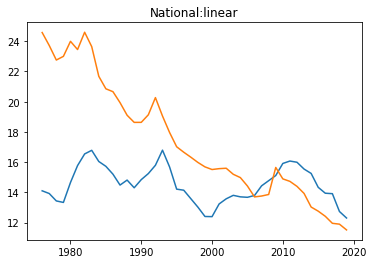

In [20]:
state = 'National'
m_to_plot = m_temp_df.loc[m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

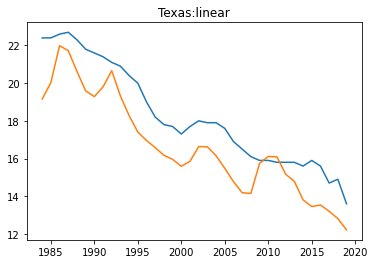

In [21]:
state = 'Texas'
m_to_plot = m_temp_df.loc[m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

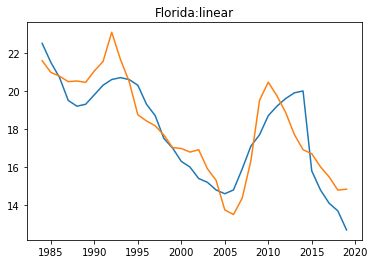

In [22]:
state = 'Florida'
m_to_plot = m_temp_df.loc[m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

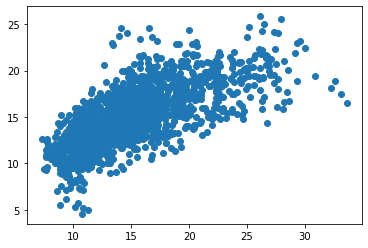

In [23]:
plt.scatter(m_temp_df['poverty_rate'], m_temp_df['predicted_poverty'])

## Comments:  Poor R2 Score overall,  individual states don't look good.  Expect forecasting to be poor.


## Model for 1 state.  Start with National.  I used 90/10 split as there are not many points to train.

In [24]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Nebraska',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Wisconsin', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wyoming'], dtype=object)

In [25]:
# Pick data for 1 state
state_to_model = 'National'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df.head()

# Define X and y variables
X1 = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y1 = model_state_df["poverty_rate"]
print(f'X shape: {X1.shape}')
X1.head()

X shape: (44, 10)


,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
1976,467.8,7.786562,5.0,7.79,2.226667,56.9,5.7,9226.48,494.549310,332.596741
1977,475.9,7.132505,5.1,7.13,2.226667,60.6,6.5,9779.44,528.450984,380.369984
1978,497.8,6.134198,5.2,6.13,2.226667,65.2,7.6,10556.03,579.812715,365.539437
1979,548.9,5.923827,5.3,5.92,2.910000,72.6,11.3,11479.46,625.455698,373.443489
1980,596.6,7.255717,5.2,7.26,3.110196,82.4,13.5,12513.46,678.387612,477.835406


In [26]:
#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

In [27]:
##
# Create a model with scikit-learn
model1 = LinearRegression()


# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X1, y1, train_size=0.8)
model1.fit(X_train, y_train)

LinearRegression()

In [28]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
#model.fit(X, y)

In [29]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values

#  Predict using all X values for ease of plotting.
y_pred = model1.predict(X1)
print(y_pred.shape)
print(X1.shape)

# Use y_pred_test to plot testing points
y_pred_test = model1.predict(X_test)

(44,)
(44, 10)


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y_test,y_pred_test)}')
print(f'Mean square error: {mean_squared_error(y_test,y_pred_test)}')
print(f'r2 score: {r2_score(y_test,y_pred_test)}')
print(f'Coefficients: {model1.coef_}')
print(f'Intercept: {model1.intercept_}')
print(f'Features: {X1.columns}')

Mean absolute error: 0.5625652864142805
Mean square error: 0.4920118309177854
r2 score: 0.7998740665868199
Coefficients: [ 3.30228536e-03  1.32460245e+01  1.83120383e+00 -1.24799969e+01
 -8.47882416e-01 -7.99765250e-03  1.14492879e-02  4.93958462e-04
 -2.61020766e-03 -2.27345597e-04]
Intercept: -3.5168977737414036
Features: Index(['crime_rate', 'unemployment_rate', 'divorce_rate_per_1000_people',
       'homeownership_rate', 'minimum_wage_effective', 'cpi_average',
       'inflation_rate', 'avg_wage_index', 'education_per_capita',
       'welfare_per_capita'],
      dtype='object')


In [31]:
model_state_df['predicted_poverty'] = y_pred
model_state_df.head()

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,
1976,467.8,7.786562,5.0,7.79,2.226667,56.9,5.7,9226.48,14.10,494.549310,332.596741,14.018997
1977,475.9,7.132505,5.1,7.13,2.226667,60.6,6.5,9779.44,13.92,528.450984,380.369984,13.955361
1978,497.8,6.134198,5.2,6.13,2.226667,65.2,7.6,10556.03,13.43,579.812715,365.539437,13.695920
1979,548.9,5.923827,5.3,5.92,2.910000,72.6,11.3,11479.46,13.33,625.455698,373.443489,13.620995
1980,596.6,7.255717,5.2,7.26,3.110196,82.4,13.5,12513.46,14.65,678.387612,477.835406,14.640372


In [32]:
X_test

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,
2010,404.5,9.768028,3.6000,9.77,7.428627,218.056,1.6,41673.83,2975.820410,2168.245578
1999,523.0,4.253037,4.1000,4.25,5.202549,166.600,2.2,30469.84,1862.920285,779.040242
1996,636.6,5.457434,4.3571,5.46,4.376863,156.900,2.9,25913.90,1609.918238,829.939892
2014,372.0,6.255356,3.2000,6.26,7.651569,236.736,1.6,46481.52,3026.592878,1557.861527
2011,387.1,9.066351,3.6000,9.07,7.440784,224.939,3.2,42979.61,2899.167798,2032.924774
1981,594.3,7.741281,5.1444,7.74,3.360196,90.900,10.3,13773.10,727.856737,564.478506
1978,497.8,6.134198,5.2000,6.13,2.226667,65.200,7.6,10556.03,579.812715,365.539437
1993,746.8,7.025515,4.5286,7.03,4.281765,144.500,3.0,23132.67,1454.126841,839.285479
2019,379.4,3.718367,2.7000,3.72,9.068824,255.657,1.8,54099.99,3602.815765,1413.607955


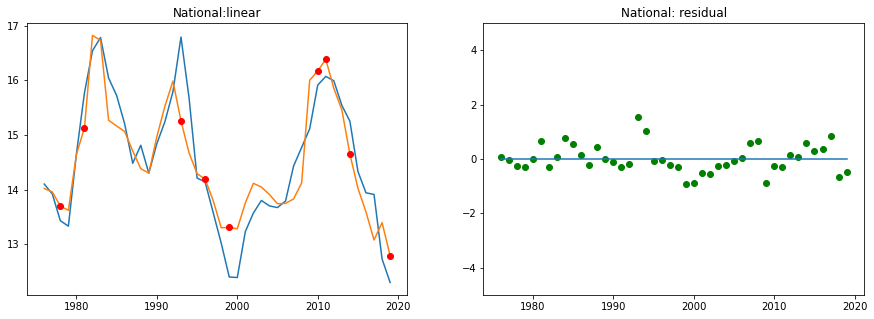

In [33]:
# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(model_state_df.index.values, model_state_df['poverty_rate'],
         model_state_df.index.values,model_state_df['predicted_poverty'])
ax[0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
ax[0].set_title(f'{state_to_model}:linear')

ax[1].plot(model_state_df.index.values, (model_state_df['poverty_rate']-model_state_df['predicted_poverty']),
          color='g', marker='o', lw=0)
ax[1].set_title(f'{state_to_model}: residual')
ax[1].set_ylim([-5,5])
ax[1].plot([model_state_df.index.values.min(),model_state_df.index.values.max()],[0,0])
plt.show()

#plt.plot(X, y_pred, color='red')
#plt.show()

In [34]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[ 4.26498807e-03  1.06086037e+00  9.42949895e-03 -3.39021256e-02
  2.63981993e-01 -9.97204285e-02  1.39413678e-01  4.26409796e-04
 -1.92670790e-03 -2.84596010e-03]
16.794198462370925


## Create Function

In [35]:
# create, train and test a model on dataframe df, filtering on state using the model_type

def run_model(df, model_type='linear'):
    training_size = 0.8
    result_df = pd.DataFrame()
    rows_plots = len(df.state.unique())
    fig, ax = plt.subplots(rows_plots,2 , figsize=(20, 5*rows_plots))
    
    for row, state in enumerate(df.state.unique()):
        m_df = df.loc[df['state']==state].dropna().set_index('year')
        m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
        X = m_df.drop(["poverty_rate"], axis=1)
        y = m_df["poverty_rate"]

    # Create a model with scikit-learn
        if model_type=='linear':
            model = LinearRegression()
        elif model_type =='ridge':
            model = Ridge(alpha=0.5)
        elif model_type == 'lasso':
            model = Lasso(alpha=0.1, max_iter=1500, tol=0.01)
        else:
            model = LinearRegression()
    
    # Test the model by using train and test dataset
    # Fit the data into the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_size)
        model.fit(X_train, y_train)
    
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
        y_pred = model.predict(X)
        m_df['predicted_poverty'] = y_pred
    
    # Use y_pred_test to plot testing points
        y_pred_test = model.predict(X_test)
        r2s = r2_score(y_test,y_pred_test)
    #m_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=f'{state}:{model_type}')
        ax[row][0].plot(m_df.index.values, m_df['poverty_rate'],
             m_df.index.values, m_df['predicted_poverty'])
        ax[row][0].plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
        ax[row][0].set_title(f'{state}: r2 score:{r2s:.3f}')
        
        ax[row][1].plot(m_df.index.values,(m_df['poverty_rate']-m_df['predicted_poverty']),color='g', marker='o', lw=0)
        ax[row][1].set_title(f'{state}: residual')
        ax[row][1].set_ylim([-5,5])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[0,0])
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[1,1], color='r')
        ax[row][1].plot([m_df.index.values.min(),m_df.index.values.max()],[-1,-1], color='r')
    
        result = { 'State': state,
                    'Model': model_type,
                    'Mean absolute error': mean_absolute_error(y_test,y_pred_test),
                    'Mean square error': mean_squared_error(y_test,y_pred_test),
                    'r2 score': r2s,
                    'Coefficients': model.coef_,
                    'Intercept': model.intercept_
                  }
        result_df = result_df.append(result, ignore_index=True)
    plt.show()
    return result_df
    

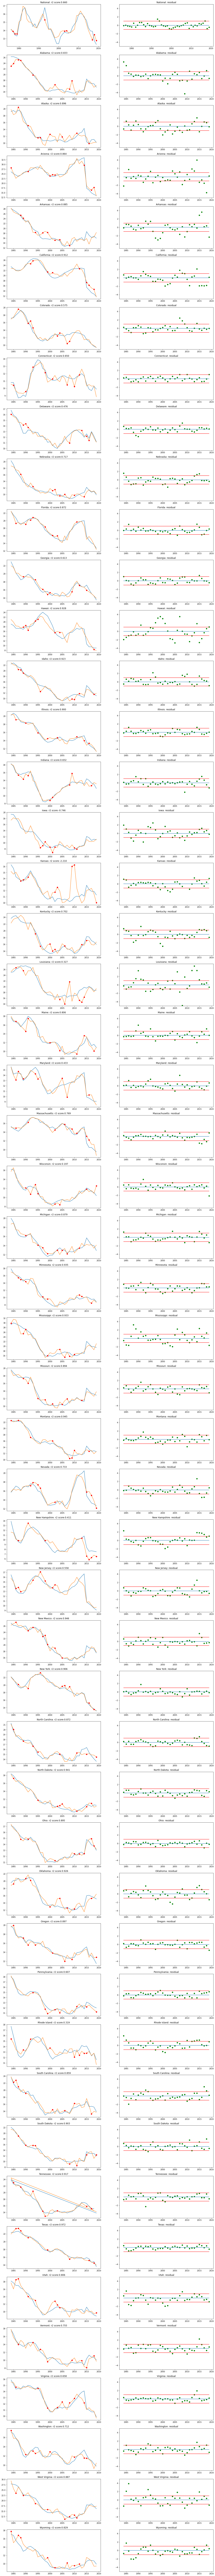

In [36]:
result_df = pd.DataFrame()

result = run_model(model_df, 'linear')
result_df = result_df.append(result, ignore_index=True)


In [37]:
result_df.sort_values(by='r2 score', ascending=False)

,Coefficients,Intercept,Mean absolute error,Mean square error,Model,State,r2 score
44,"[-0.003072414209191206, 0.7319155183538897, -0...",41.158387,0.502510,0.289191,linear,Texas,0.971634
32,"[0.015163727831015323, 0.8284059431633661, 4.2...",30.007567,0.629050,0.673973,linear,New Mexico,0.945590
28,"[-0.0012402372617881876, -0.22127596695439958,...",88.629646,0.884765,1.111823,linear,Montana,0.944678
35,"[0.01165782398316927, 0.2887694950735961, -5.8...",72.028730,0.516269,0.417817,linear,North Dakota,0.940898
25,"[-0.012273528707017513, 0.4352423395734767, -3...",68.356611,0.676924,0.543601,linear,Minnesota,0.935434
26,"[0.0099229232822729, 1.528897638486618, -9.021...",146.888688,1.153251,2.083920,linear,Mississippi,0.933325
12,"[0.03176061942272764, 2.238872195623123, -7.80...",29.406159,0.821342,1.027963,linear,Hawaii,0.928145
37,"[0.020463961578273324, 1.353200483538087, -3.4...",45.780608,0.722171,0.966606,linear,Oklahoma,0.926135
13,"[0.020980712211841394, 0.36190443172448267, 4....",-0.261077,0.963056,1.411748,linear,Idaho,0.922558
43,"[-0.003615054510630436, 0.8025035006123835, -2...",94.179690,0.605178,0.868630,linear,Tennessee,0.916886


## Count how many states and rows of data we end if we ignore (Drop) states with low r2 score.

In [49]:
r2_cutoff = 0.80
states_to_keep = result_df.loc[result_df['r2 score']>=r2_cutoff].State.unique()
if ~('National' in states_to_keep):
    states_to_keep = np.append(states_to_keep,'National')
print(len(states_to_keep))
states_to_keep

31


array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Maine',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'West Virginia', 'Wyoming',
       'National'], dtype=object)

In [50]:
trimmed_data_df = model_df.loc[model_df['state'].isin(states_to_keep)].dropna()
trimmed_data_df.shape

(1124, 13)

In [51]:
trimmed_data_df

,year,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
6,1976,National,467.8,7.786562,5.00,7.79,2.226667,56.900,5.7,9226.48,14.10,494.549310,332.596741
7,1977,National,475.9,7.132505,5.10,7.13,2.226667,60.600,6.5,9779.44,13.92,528.450984,380.369984
8,1978,National,497.8,6.134198,5.20,6.13,2.226667,65.200,7.6,10556.03,13.43,579.812715,365.539437
9,1979,National,548.9,5.923827,5.30,5.92,2.910000,72.600,11.3,11479.46,13.33,625.455698,373.443489
10,1980,National,596.6,7.255717,5.20,7.26,3.110196,82.400,13.5,12513.46,14.65,678.387612,477.835406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,2015,Wyoming,221.6,4.200000,3.10,69.90,7.250000,237.017,0.1,48098.63,10.60,5102.901024,544.368601
2953,2016,Wyoming,244.7,5.400000,3.01,70.20,7.250000,240.007,1.3,48642.15,10.90,5437.606838,613.333333
2954,2017,Wyoming,234.6,4.300000,2.90,70.40,7.250000,245.120,2.1,50321.89,10.80,5340.172414,620.862069
2955,2018,Wyoming,213.8,4.000000,2.90,71.10,7.250000,251.107,2.4,52145.80,10.70,4799.136442,586.528497


##  What if we use this trimmed dataset to train a single model?

In [52]:
new_m_df = trimmed_data_df.dropna().set_index('year')
new_m_temp_df = new_m_df.copy()
new_m_df.drop(columns=['state'], inplace=True)
new_m_df

,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
year,,,,,,,,,,,
1976,467.8,7.786562,5.00,7.79,2.226667,56.900,5.7,9226.48,14.10,494.549310,332.596741
1977,475.9,7.132505,5.10,7.13,2.226667,60.600,6.5,9779.44,13.92,528.450984,380.369984
1978,497.8,6.134198,5.20,6.13,2.226667,65.200,7.6,10556.03,13.43,579.812715,365.539437
1979,548.9,5.923827,5.30,5.92,2.910000,72.600,11.3,11479.46,13.33,625.455698,373.443489
1980,596.6,7.255717,5.20,7.26,3.110196,82.400,13.5,12513.46,14.65,678.387612,477.835406
...,...,...,...,...,...,...,...,...,...,...,...
2015,221.6,4.200000,3.10,69.90,7.250000,237.017,0.1,48098.63,10.60,5102.901024,544.368601
2016,244.7,5.400000,3.01,70.20,7.250000,240.007,1.3,48642.15,10.90,5437.606838,613.333333
2017,234.6,4.300000,2.90,70.40,7.250000,245.120,2.1,50321.89,10.80,5340.172414,620.862069


In [53]:
# Define X and y variables
new_X = new_m_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
new_y = new_m_df["poverty_rate"]
print(f'X shape: {new_X.shape}')
# Create a model with scikit-learn
new_model = LinearRegression()
# Test the model by using train and test dataset
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, train_size=0.8)
new_model.fit(new_X_train, new_y_train)
#  Predict using all X values for ease of plotting.
new_y_pred = new_model.predict(new_X)
print(new_y_pred.shape)
print(new_X.shape)

# Use y_pred_test to plot testing points
new_y_pred_test = new_model.predict(new_X_test)
print(f'Mean absolute error: {mean_absolute_error(new_y_test,new_y_pred_test)}')
print(f'Mean square error: {mean_squared_error(new_y_test,new_y_pred_test)}')
print(f'r2 score: {r2_score(new_y_test,new_y_pred_test)}')
print(f'Coefficients: {new_model.coef_}')
print(f'Intercept: {new_model.intercept_}')

X shape: (1124, 10)
(1124,)
(1124, 10)
Mean absolute error: 2.5215252487990116
Mean square error: 10.05746436008195
r2 score: 0.4498766401053569
Coefficients: [ 4.01143589e-03  9.97854501e-01  1.02894410e+00 -2.28152549e-02
  3.79014168e-01 -7.20621588e-02  5.78737657e-02  3.29575775e-04
 -2.22035273e-03 -1.74692387e-03]
Intercept: 10.901573662526044


In [54]:
new_m_temp_df['predicted_poverty'] = new_y_pred
#m_df['state']=model_df.dropna()['state']
new_m_temp_df.head()

,state,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,,
1976,National,467.8,7.786562,5.0,7.79,2.226667,56.9,5.7,9226.48,14.10,494.549310,332.596741,23.950180
1977,National,475.9,7.132505,5.1,7.13,2.226667,60.6,6.5,9779.44,13.92,528.450984,380.369984,23.251153
1978,National,497.8,6.134198,5.2,6.13,2.226667,65.2,7.6,10556.03,13.43,579.812715,365.539437,22.368535
1979,National,548.9,5.923827,5.3,5.92,2.910000,72.6,11.3,11479.46,13.33,625.455698,373.443489,22.600340
1980,National,596.6,7.255717,5.2,7.26,3.110196,82.4,13.5,12513.46,14.65,678.387612,477.835406,23.525130


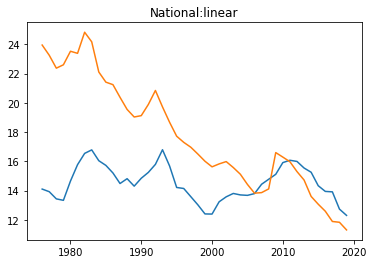

In [55]:
state = 'National'
m_to_plot = new_m_temp_df.loc[new_m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

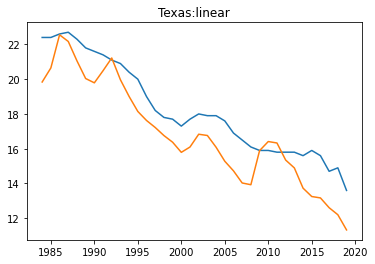

In [56]:
state = 'Texas'
m_to_plot = new_m_temp_df.loc[new_m_temp_df['state']==state]
plt.plot(m_to_plot.index.values, m_to_plot['poverty_rate'],
         m_to_plot.index.values,m_to_plot['predicted_poverty'])
#plt.plot(X_test.index, y_pred_test, color='r', marker='o', lw=0)
plt.title(f'{state}:linear')
plt.show()

## Not a whole lot better!